In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob

# Set global settings

In [2]:
fft = np.fft.fftn
ifft = np.fft.ifftn
xwidth, ywidth, twidth = 12, 12, 12

# Make noisy data

In [66]:
#filename = "/Users/mhughes/google_drive/codedungeon/sun_selector/data/thm_files/set_10/OR_SUVI-L1b-Fe195_G16_s20170911037044_e20170911037054_c20170911037188.fits"
#filename = "/Users/mhughes/Desktop/noisy.fits"
outfile = "/Users/mhughes/Desktop/gated.fits"
image_file = fits.open(filename)
data = image_file[0].data
#data = np.power(data, 0.25)
data[np.isnan(data)] = 0
data[np.isinf(data)] = 0

In [2]:
new_data = np.zeros((1280, 1280, 100))
for t in range(new_data.shape[2]):
    new_data[:,:,t] = data + np.random.poisson(data)
data = new_data

# Use real data

In [32]:
fns = glob.glob("/Volumes/Herschel/proc_fits/94/*")
#fns = fns[:45]
data = np.zeros((1280, 1280, len(fns)))
for i, fn in enumerate(fns):
    image_file = fits.open(fn)
    img = image_file[0].data.copy()
    img[np.isnan(img)] = 0
    img[np.isinf(img)] = 0
    data[:,:,i] = img
    #data[:,:,i] = (img + np.random.poisson(img))
    image_file.close()

In [5]:
data.shape

(1280, 1280, 90)

# Take a look at the image

In [ ]:
np.max

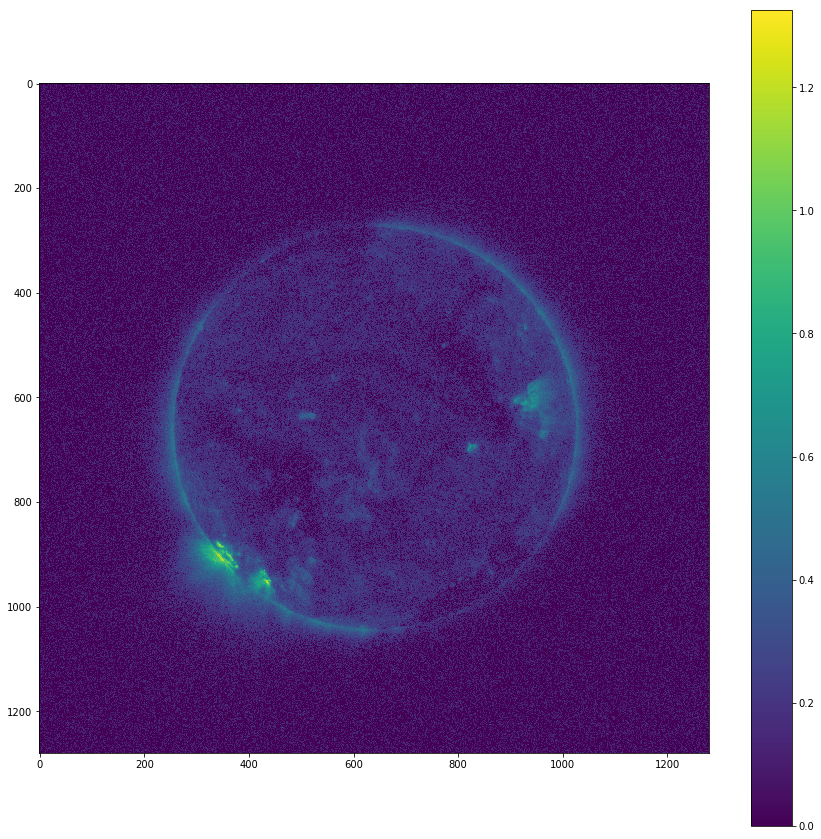

In [33]:
plt.figure(figsize=(15,15))
plt.imshow(np.sqrt(data[:,:,5]))
plt.colorbar()
plt.show()

In [85]:
data.nbytes / 10**9

0.589824

# Define all image section coordinates

In [34]:
# define grid
#xstart, xend, xstep = xwidth*2, data.shape[0] - (xwidth*2), int(xwidth)
#xstart, xend, xstep  = 600, 800, 3
xstart, xend, xstep = xwidth*2, data.shape[0] - (xwidth*2), 3
#ystart, yend, ystep = ywidth*2, data.shape[1] - (ywidth*2), int(ywidth)
#ystart, yend, ystep = 600, 800, 3
ystart, yend, ystep = ywidth*2, data.shape[1] - (ywidth*2), 3
#tstart, tend, tstep = twidth*2, data.shape[2] - (twidth*2), int(twidth)
tstart, tend, tstep = twidth, data.shape[2] - twidth, 3
x_ = np.arange(xstart, xend, xstep)
y_ = np.arange(ystart, yend, ystep)
t_ = np.arange(tstart, tend, tstep)
coords = []
for t in t_:
    for y in y_:
        for x in x_:
            coords.append((x,y,t))

#  Define hanning window

In [35]:
#NX, NY, NT = 2*xwidth+1, 2*ywidth+1, 2*twidth+1
NX, NY, NT = xwidth, ywidth, twidth
hanning_window_3D = lambda x, y, t : (np.power(np.sin((x + 0.5)*np.pi / NX), 2.0) * 
                                       np.power(np.sin((y + 0.5) * np.pi / NY), 2.0) * 
                                       np.power(np.sin((t + 0.5) * np.pi / NT), 2.0))

hanning = np.zeros((NX, NY, NT))
for x in range(hanning.shape[0]):
    for y in range(hanning.shape[1]):
        for t in range(hanning.shape[2]):
            hanning[x,y,t] = hanning_window_3D(x,y,t)

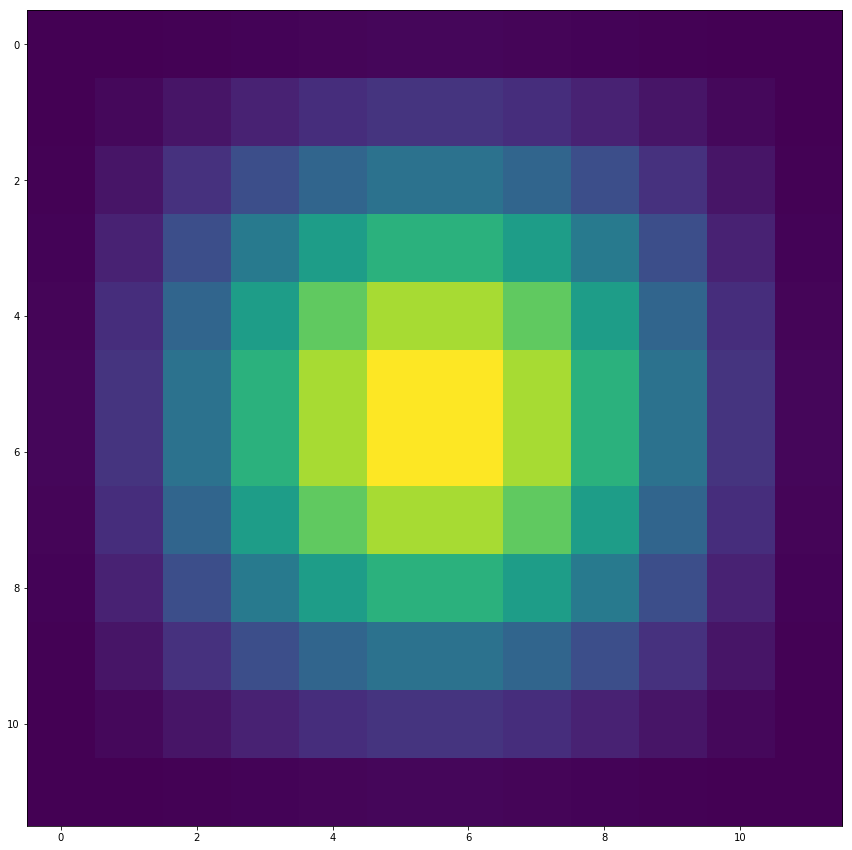

In [36]:
plt.figure(figsize=(15,15))
plt.imshow(hanning[:,:,0])
plt.show()

# Determine beta

In [37]:
beta_stack = []
for i in np.random.choice(len(coords),10000):
    x, y, t = coords[i]
    #image_section = data[x-xwidth : x+xwidth + 1,
    #                     y-ywidth : y+ywidth + 1, 
    #                     t-twidth : t+twidth+1].copy()
    image_section = data[x-xwidth//2 : x+xwidth//2, 
                         y-ywidth//2 : y+ywidth//2, 
                         t-twidth//2 : t+twidth//2].copy()
    image_section *= hanning
    imbar = np.sum(np.sqrt(image_section))
    beta_fourier = fft(image_section)
    #beta_fourier_magnitude = np.log(np.power(np.abs(beta_fourier), 2.0))
    beta_fourier_magnitude = np.abs(beta_fourier)
    beta_stack.append(beta_fourier_magnitude / imbar)
beta_approx = np.median(np.stack(beta_stack), axis=0)

In [232]:
beta_approx = np.percentile(np.stack(beta_stack), 40, axis=0)

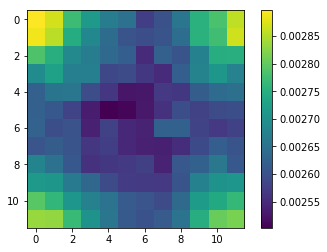

In [38]:
plt.imshow(beta_approx[:,:,10])
plt.colorbar()
plt.show()

In [14]:
del beta_stack

# Process a single image section

In [108]:
len(coords)

14400

In [110]:
x, y, t = coords[2000]
print(x,y,t)

625 710 36


In [111]:
image_section = data[x-xwidth : x+xwidth + 1,
                         y-ywidth : y+ywidth + 1, 
                         t-twidth : t+twidth+1]

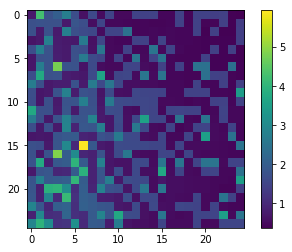

In [112]:
plt.imshow(image_section[:,:,12])
plt.colorbar()
plt.show()

In [113]:
image_section *= hanning

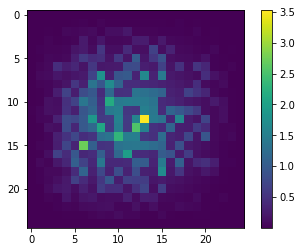

In [114]:
plt.imshow(image_section[:,:,12])
plt.colorbar()
plt.show()

In [115]:
imbar = np.sum(np.sqrt(image_section))

In [116]:
print(imbar)

4301.24449395


In [117]:
fourier = fft(image_section)
fourier_magnitude = np.log(np.power(np.abs(fourier), 2.0))

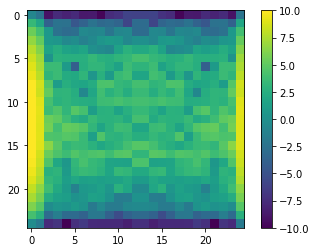

In [118]:
plt.imshow(fourier_magnitude[:,:,0], vmin=-10, vmax=10)
plt.colorbar()
plt.show()

In [119]:
noise = beta_approx * imbar
threshold = noise * 3
gate_filter = np.logical_not(fourier_magnitude < threshold)
wiener_filter =  (fourier_magnitude / threshold) / (1 + (fourier_magnitude / threshold))

In [120]:
final_fourier = fourier * wiener_filter
final_image = hanning * np.abs(ifft(final_fourier))

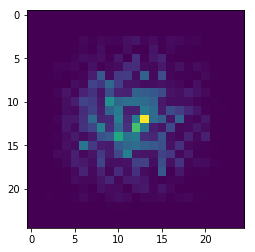

In [121]:
plt.imshow(final_image[:,:,12])
plt.show()

In [40]:
print("4")

4


# Do for the full image

In [ ]:
import time
gated_image = np.zeros_like(data)
times = []
for i in range(len(coords)):
    start = time.time()
    x, y, t = coords[i]
    #image_section = data[x-xwidth : x+xwidth + 1,
    #                     y-ywidth : y+ywidth + 1, 
    #                     t-twidth : t+twidth+1].copy()
    image_section = data[x-xwidth//2 : x+xwidth//2, 
                         y-ywidth//2 : y+ywidth//2, 
                         t-twidth//2 : t+twidth//2].copy()
    image_section *= hanning
    imbar = np.sum(np.sqrt(image_section))
    fourier = fft(image_section)
    #fourier_magnitude = np.log(np.power(np.abs(fourier), 2.0))
    fourier_magnitude = np.abs(fourier)
    noise = beta_approx * imbar
    threshold = noise * 3.0
    gate_filter = np.logical_not(fourier_magnitude < threshold)
    #gate_filter = fourier_magnitude < threshold
    #wiener_filter =  (fourier_magnitude / threshold) / (1 + (fourier_magnitude / threshold))
    #final_fourier = fourier * wiener_filter
    final_fourier = fourier * gate_filter
    final_image = hanning * np.abs(ifft(final_fourier))
    gated_image[x-xwidth//2 : x+xwidth//2,
                y-ywidth//2 : y+ywidth//2, 
                t-twidth//2 : t+twidth//2] += final_image
    #gated_image[x-xwidth : x+xwidth + 1,
    #            y-ywidth : y+ywidth + 1, 
    #            t-twidth : t+twidth + 1] += final_image
    times.append(time.time() - start)


In [180]:
np.median(times) * 180000

123.66056442260742

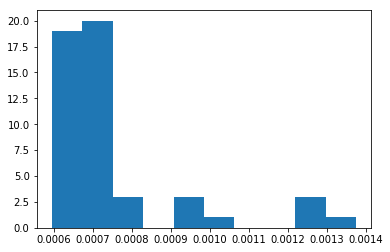

In [154]:
plt.hist(times)
plt.show()

In [19]:
f = fits.open("/Volumes/Herschel/proc_fits/171/SUVI_171_20170418_180253.fits")

In [23]:
fns[40]

'/Volumes/Herschel/proc_fits/171/SUVI_171_20170418_204253.fits'

In [24]:
f[0].data = data[:,:,40]
f.writeto("/Users/mhughes/Desktop/SUVI_171_20170418_204253_messy.fits")

In [28]:
f[0].data = gated_image[:,:,40]
f.writeto("/Users/mhughes/Desktop/SUVI_171_20170418_204253_cleaned_wiener.fits")

In [51]:
%matplotlib notebook

In [56]:
np.sum(times)

4677.54416680336

In [61]:
np.sum(times) / data.shape[2]

25.98635648224089

<IPython.core.display.Javascript object>


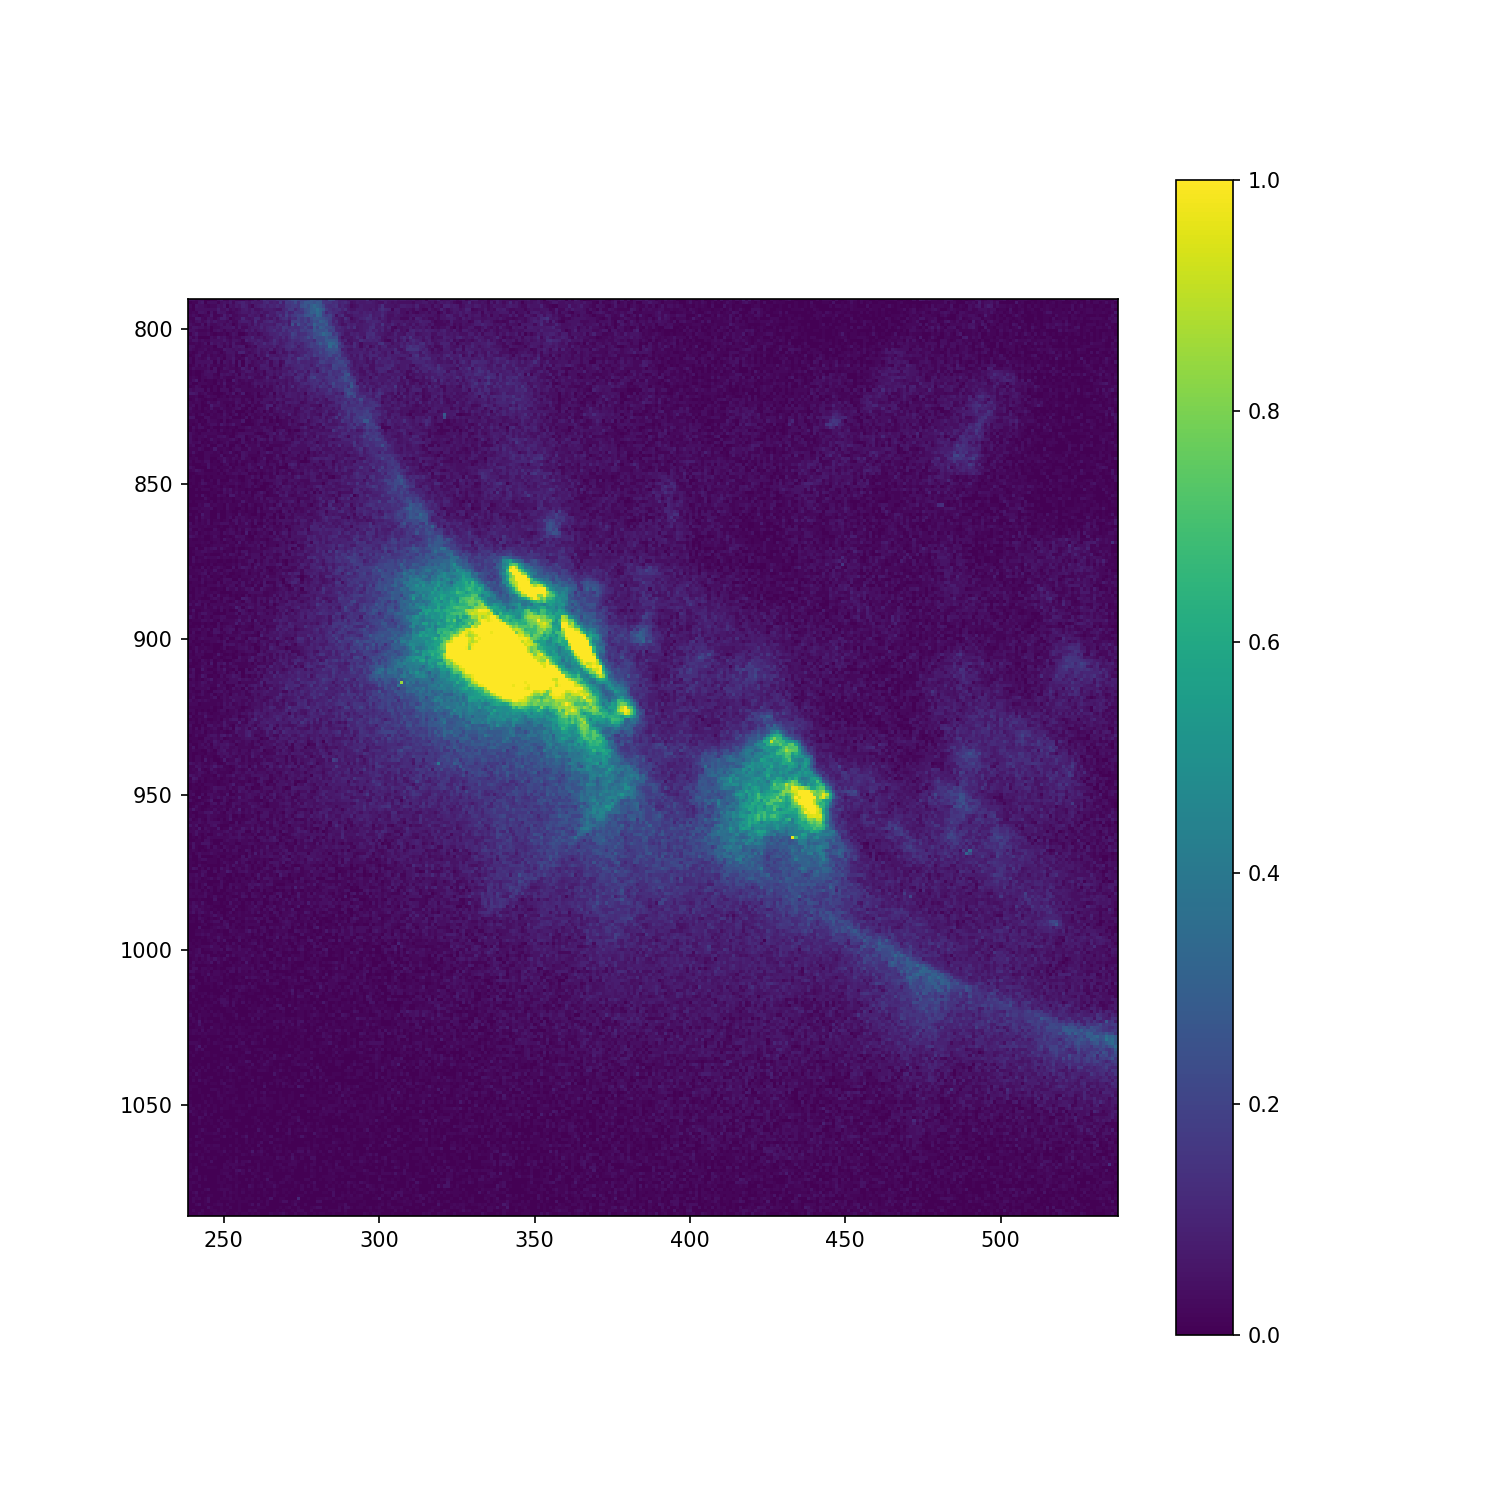

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(data[:,:,40], vmax=1)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


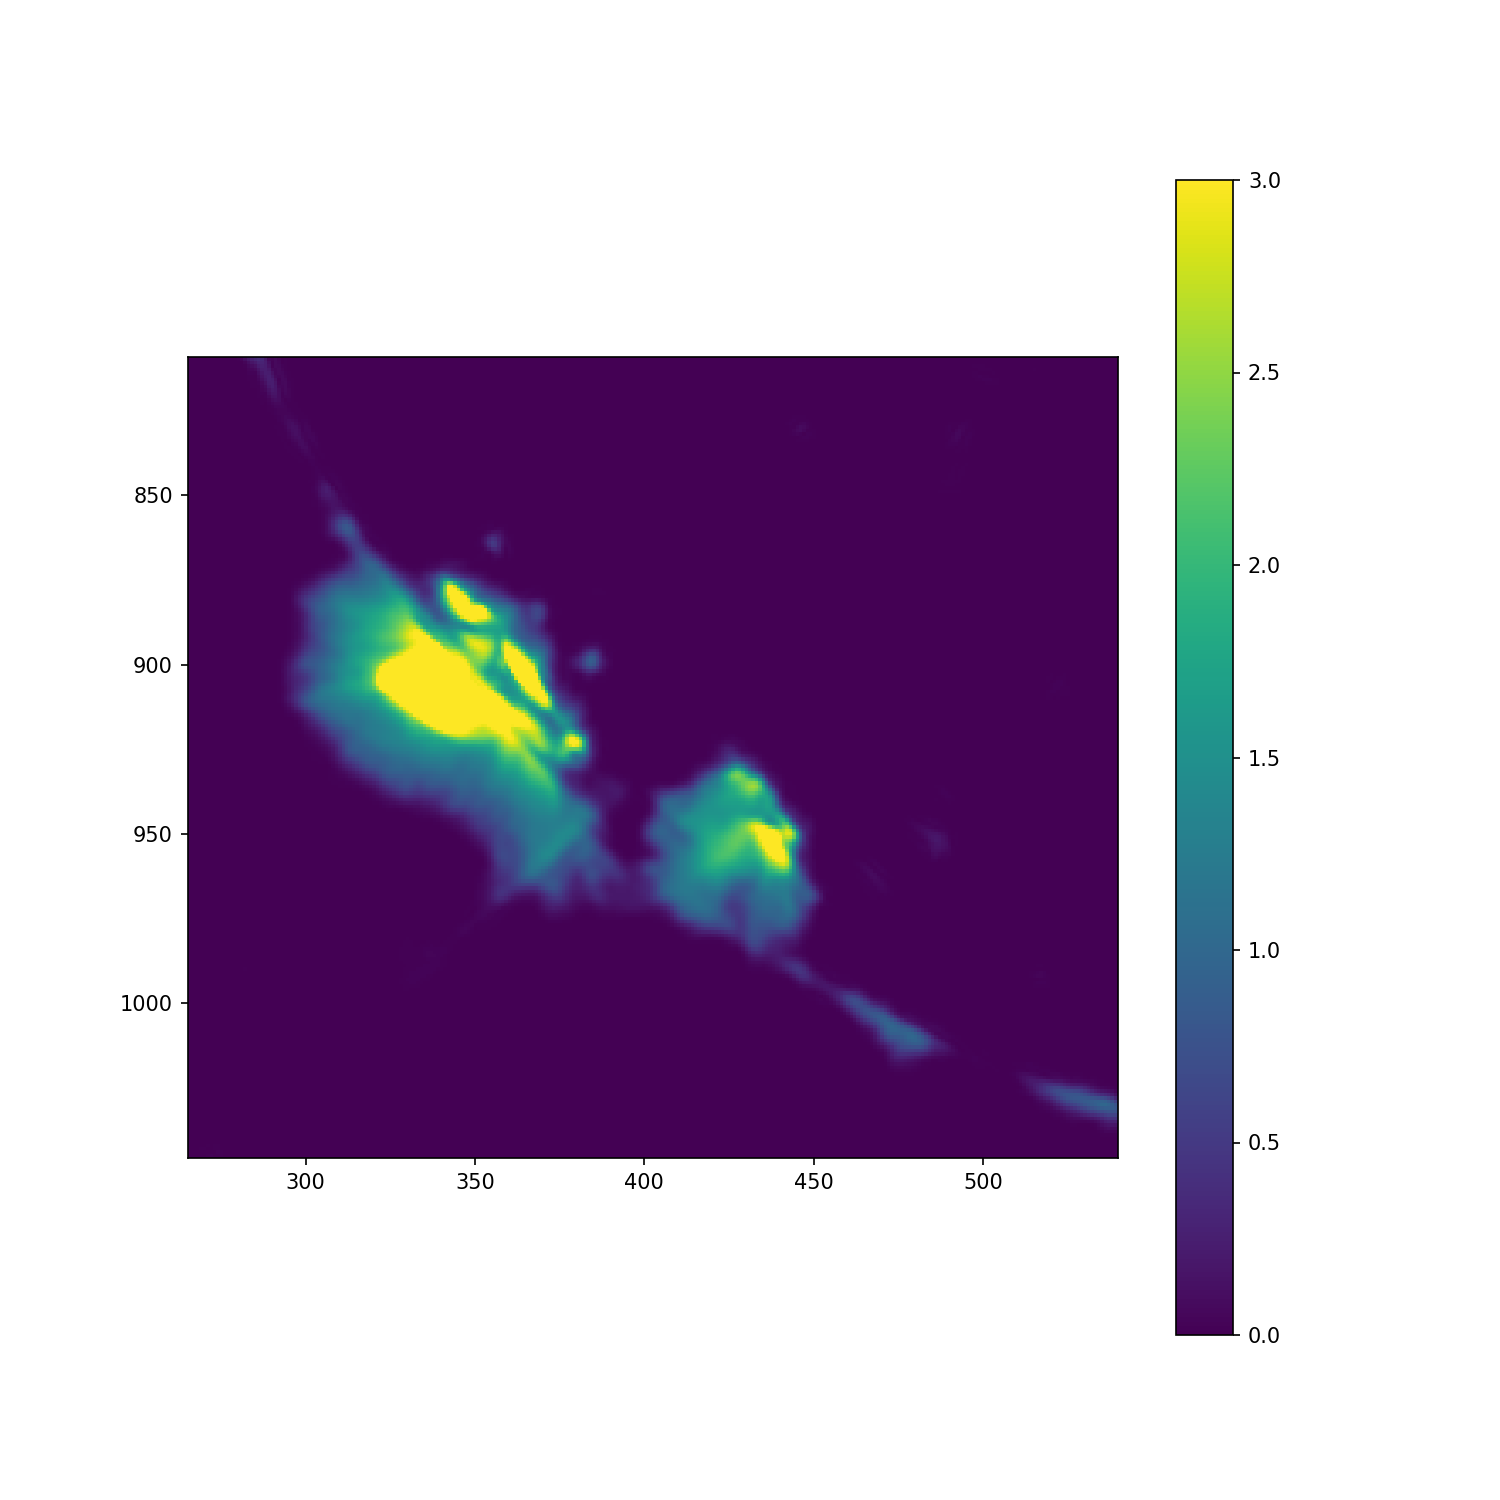

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(gated_image[:,:,40], vmax=3)
plt.colorbar()
plt.show()

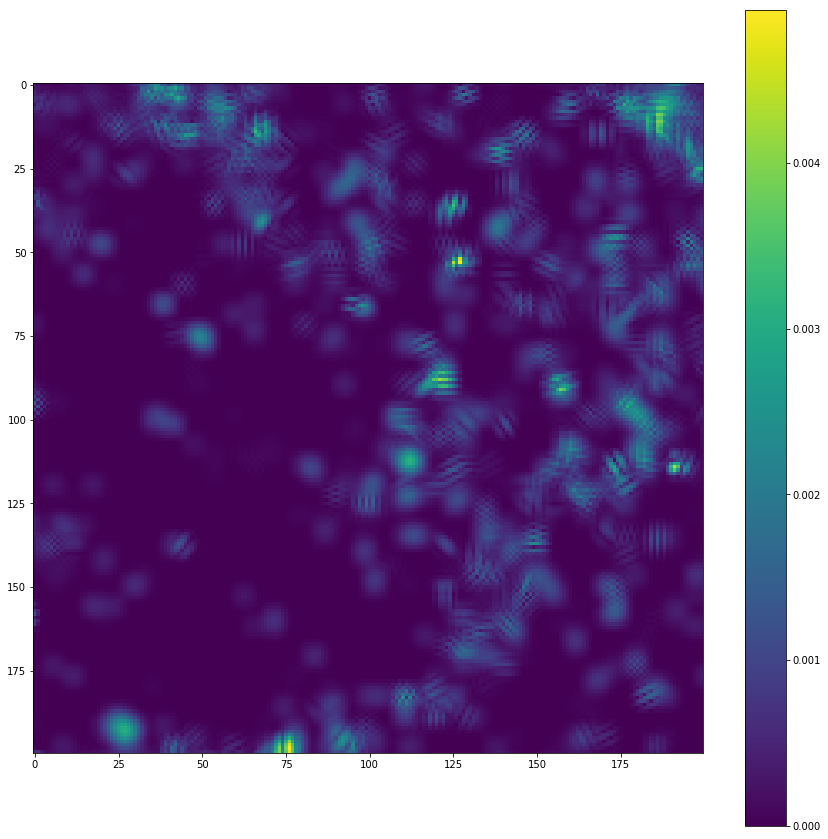

In [42]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,40])
plt.colorbar()
plt.show()

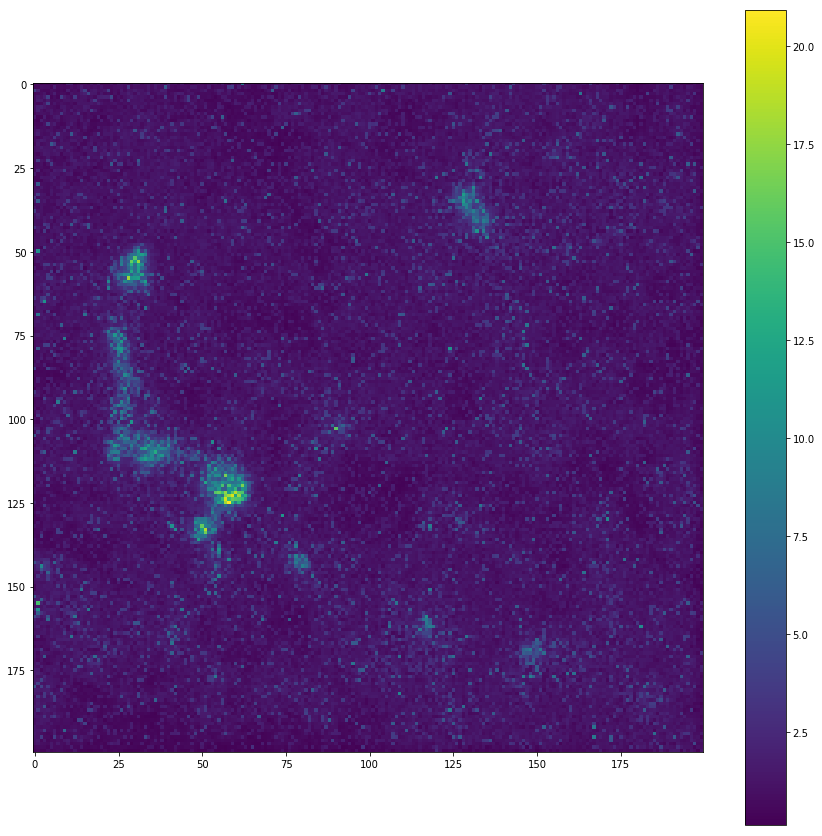

In [234]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,40])
plt.colorbar()
plt.show()

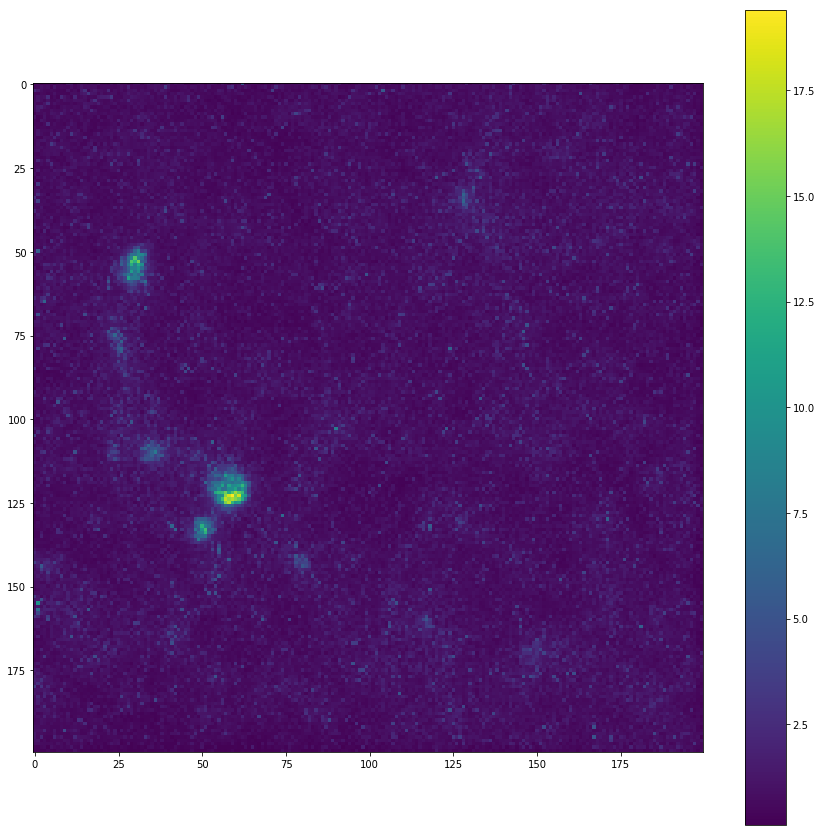

In [231]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,40])
plt.colorbar()
plt.show()

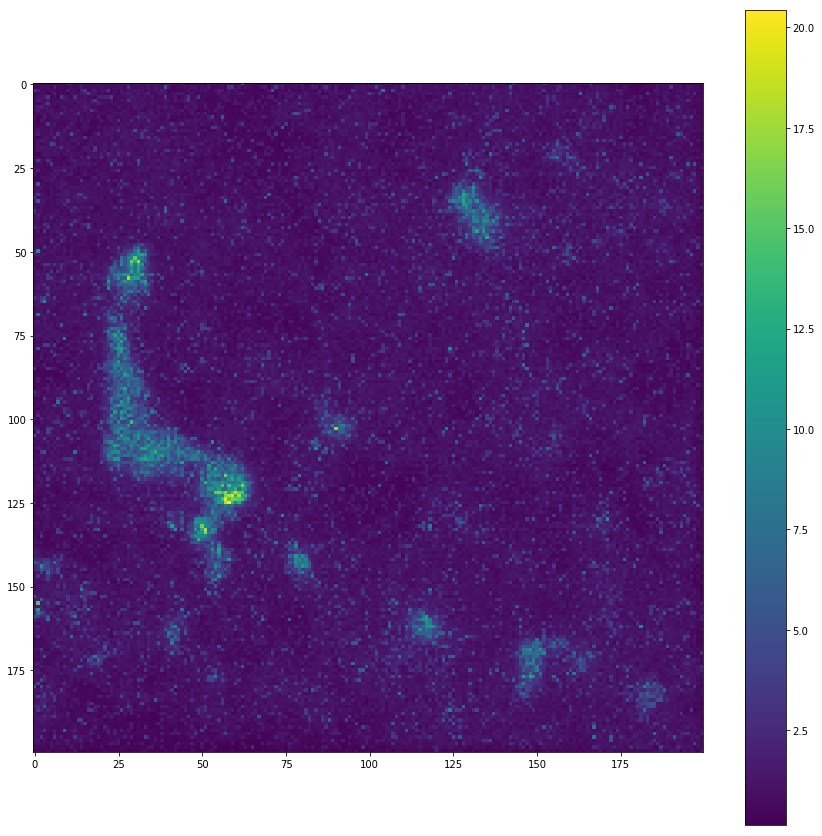

In [227]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,40])
plt.colorbar()
plt.show()

In [94]:
np.median(data[600:800,600:800,12])

0.5760541558265686

In [93]:
np.median(gated_image[600:800,600:800,12])

58.333234287775014

In [92]:
338 / 8

42.25

percentile = 25

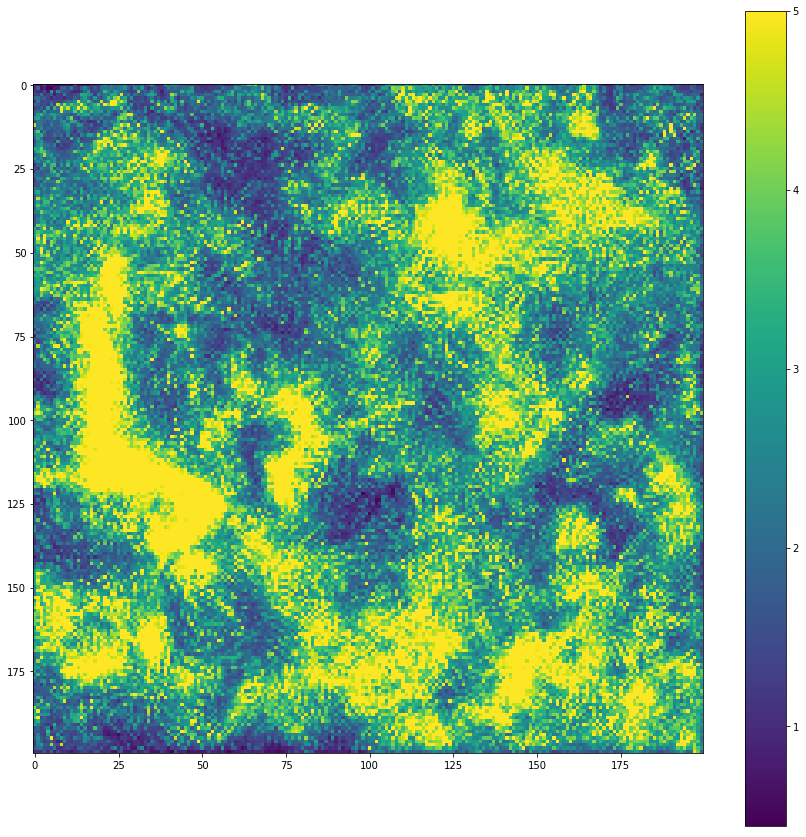

In [52]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

percentile = 45

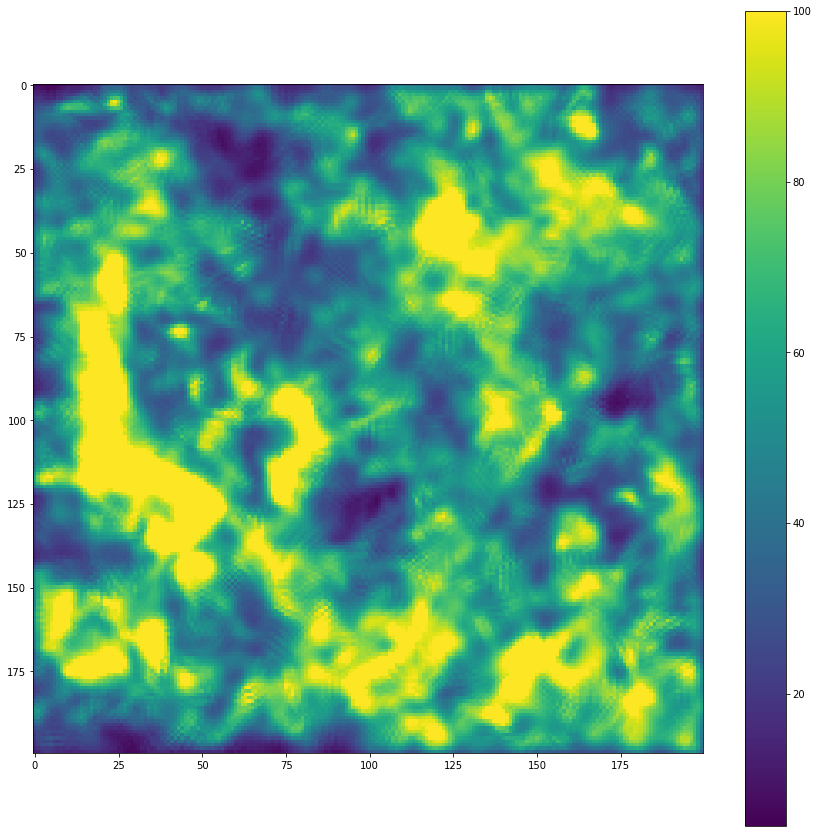

In [88]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=100, interpolation = 'None')
plt.colorbar()
plt.show()

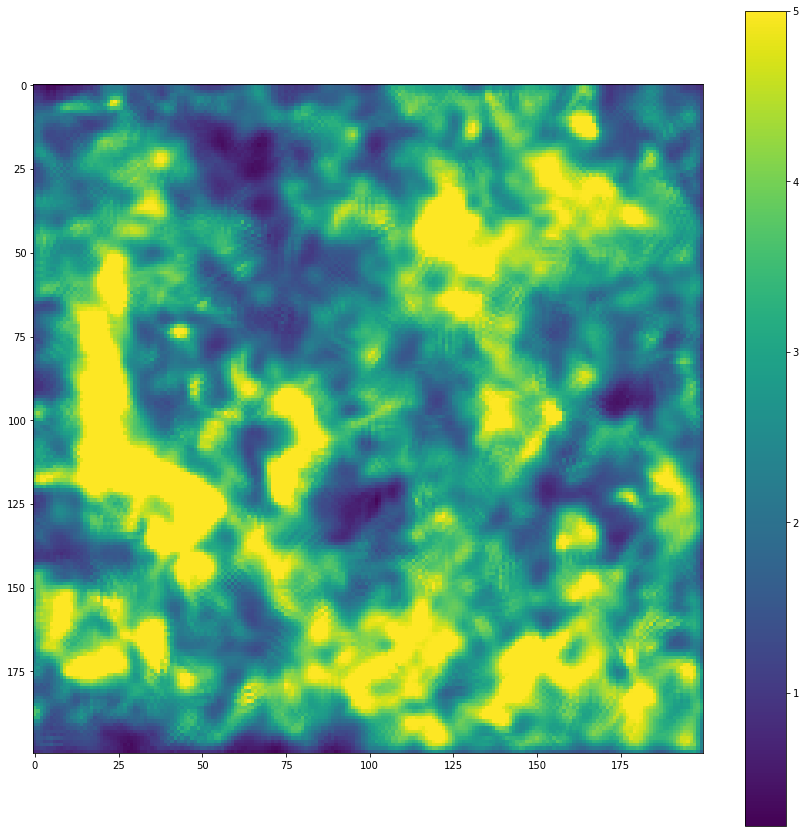

In [77]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5, interpolation = 'None')
plt.colorbar()
plt.show()

percentile = 50

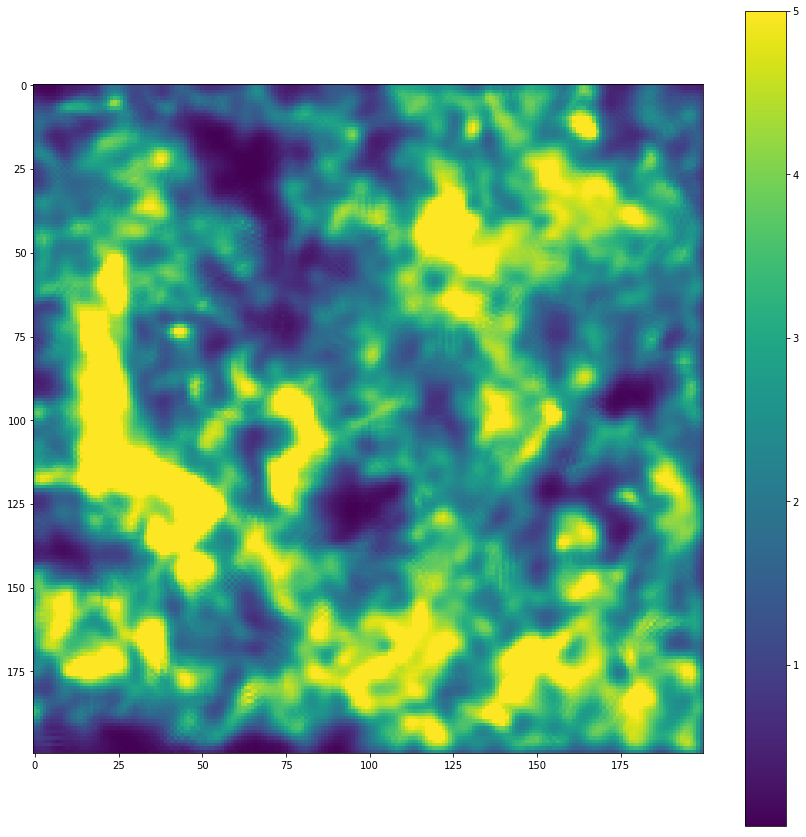

In [68]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

percentile = 55

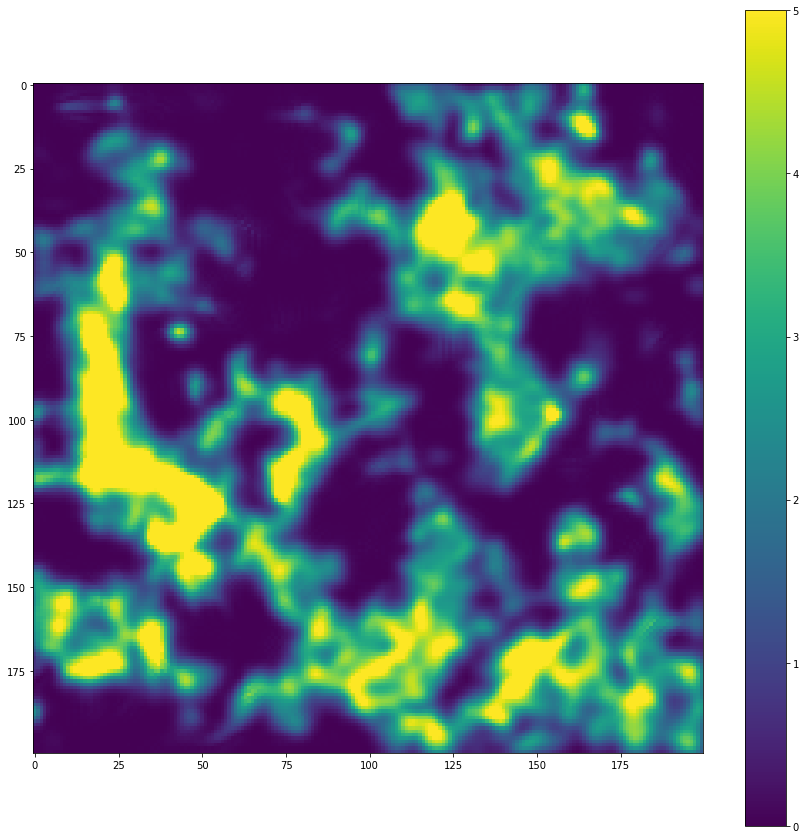

In [65]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

percentile = 60

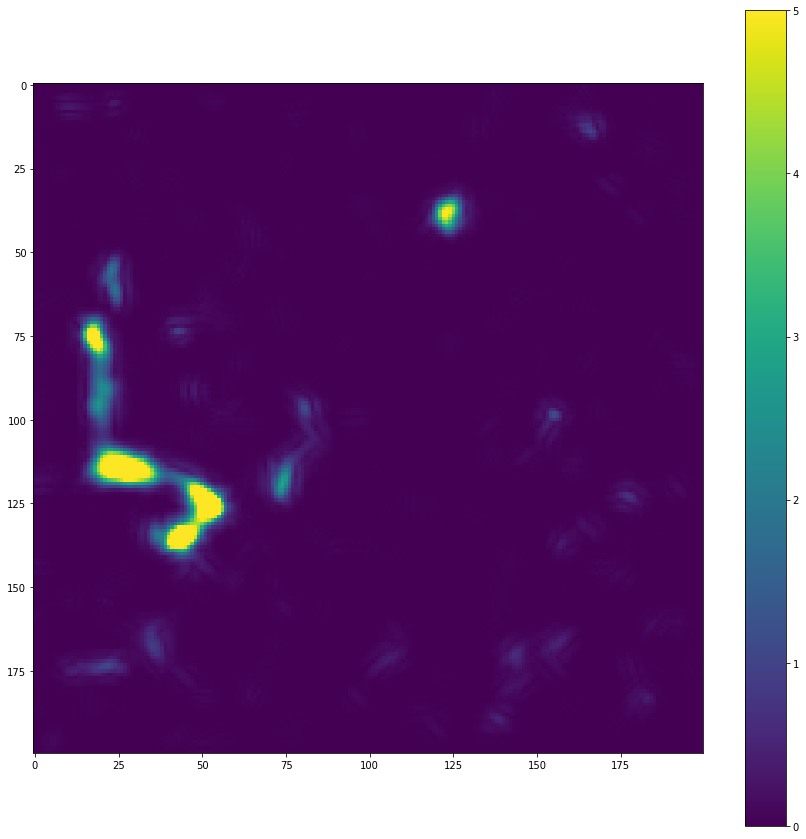

In [61]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

percentinle = 75 

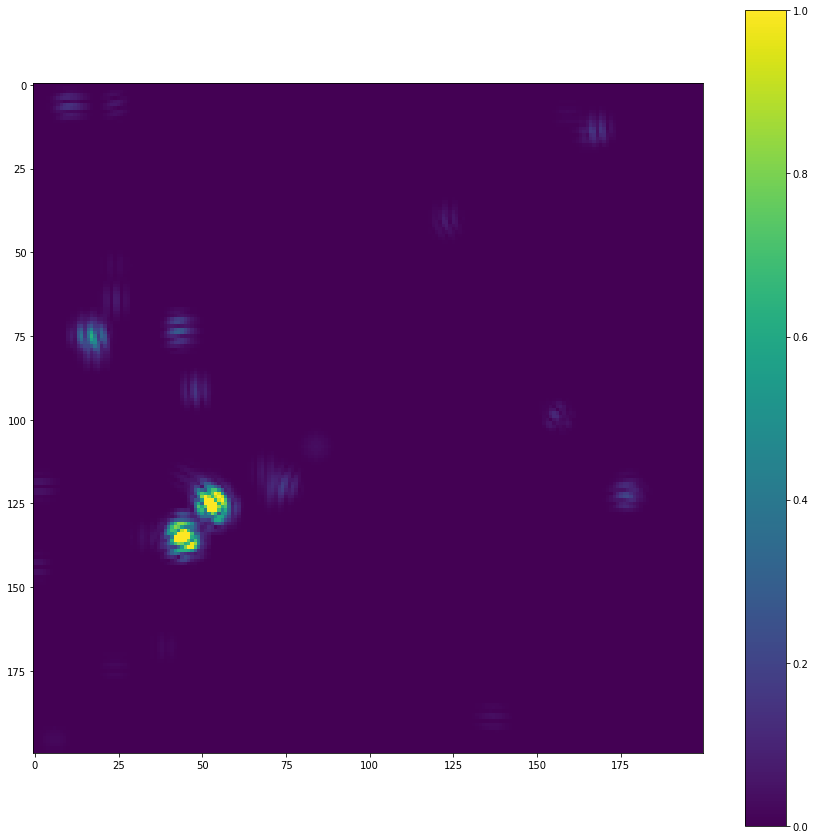

In [57]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=1)
plt.colorbar()
plt.show()

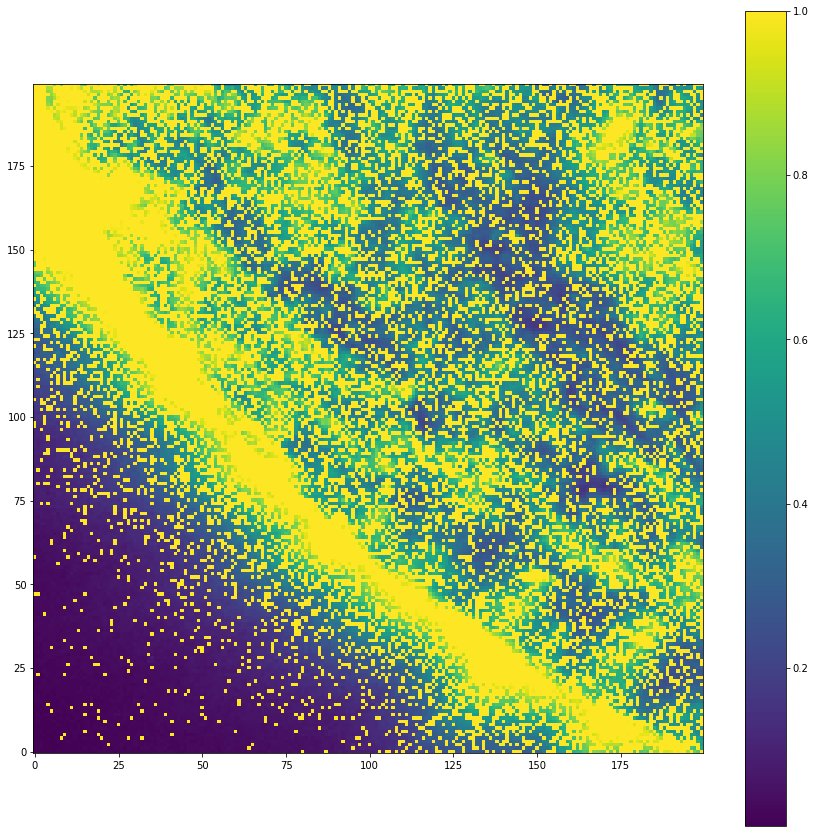

In [30]:
plt.figure(figsize=(15,15))
plt.imshow(data[300:500,300:500,12], vmax=1, interpolation='None', origin='lower')
plt.colorbar()
plt.show()

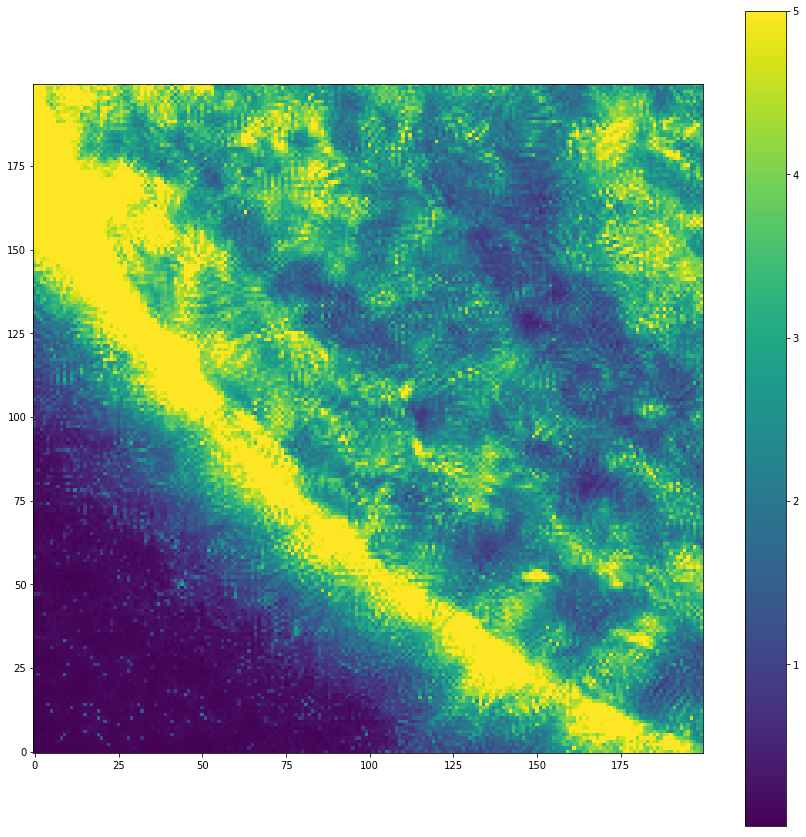

In [29]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[300:500,300:500,12], vmax=5, interpolation='None', origin='lower')
plt.colorbar()
plt.show()

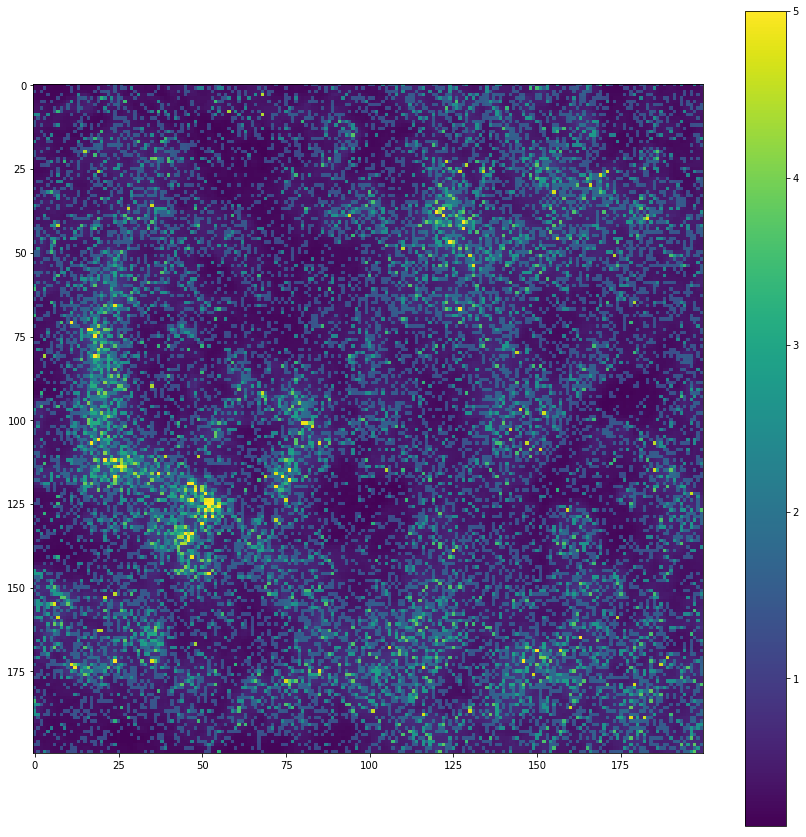

In [199]:
plt.figure(figsize=(15,15))
plt.imshow(data[600:800,600:800,12], vmax=5)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

gate: Below gamma is 2

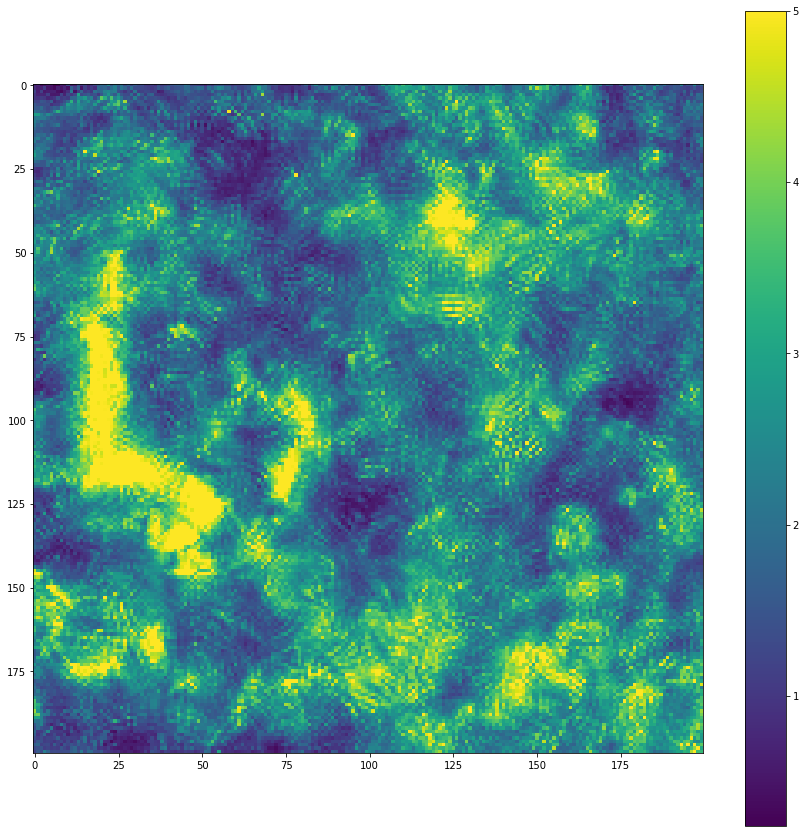

In [186]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

wiener: below gamma is 2

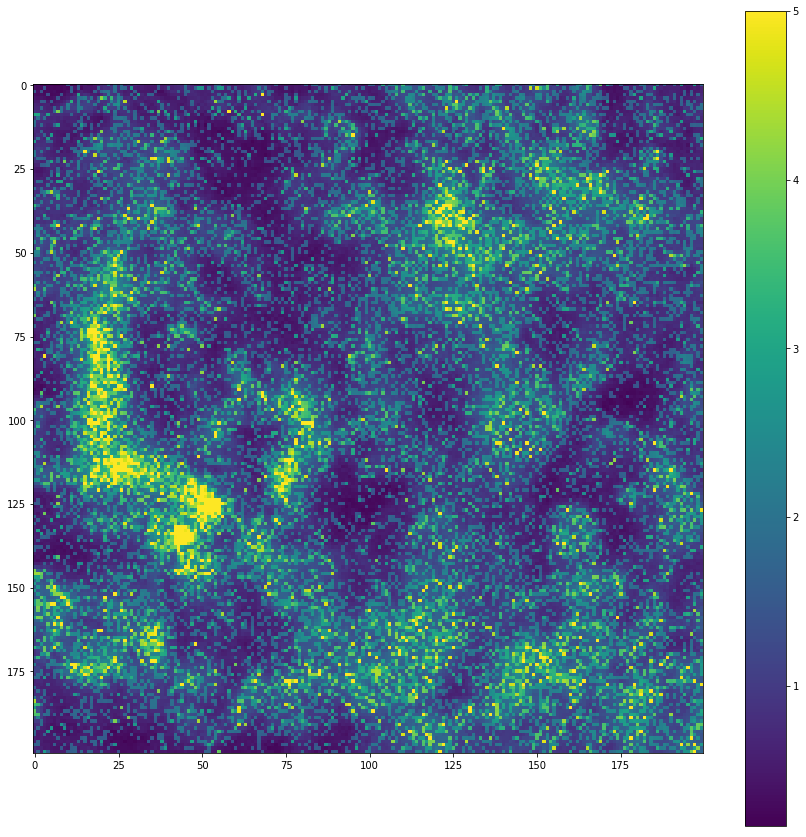

In [188]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

gate: Below gamma is 3

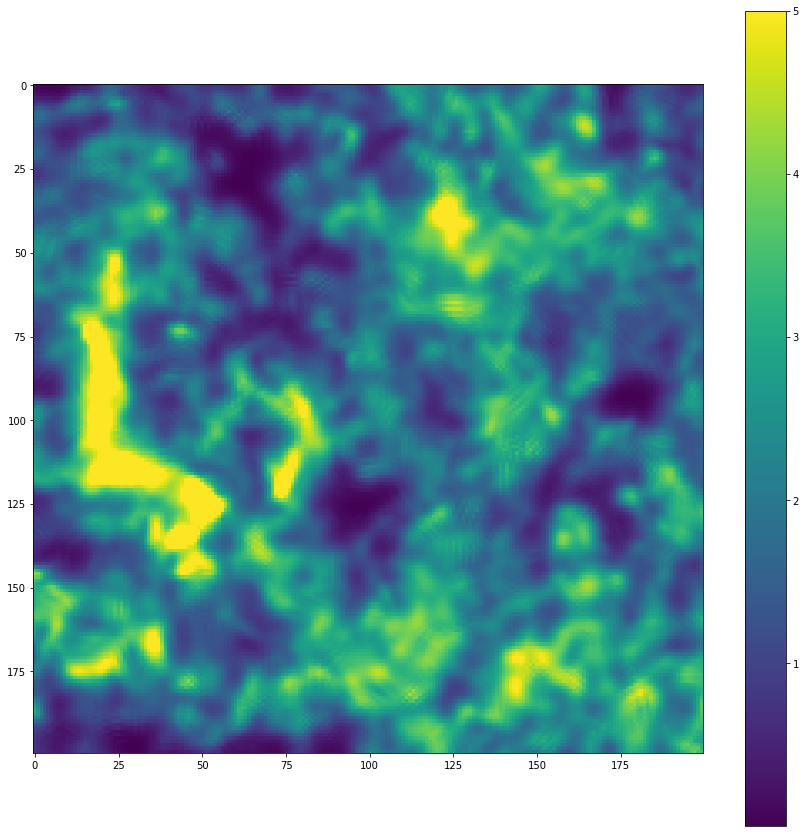

In [184]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

Wiener: below gamma is 3

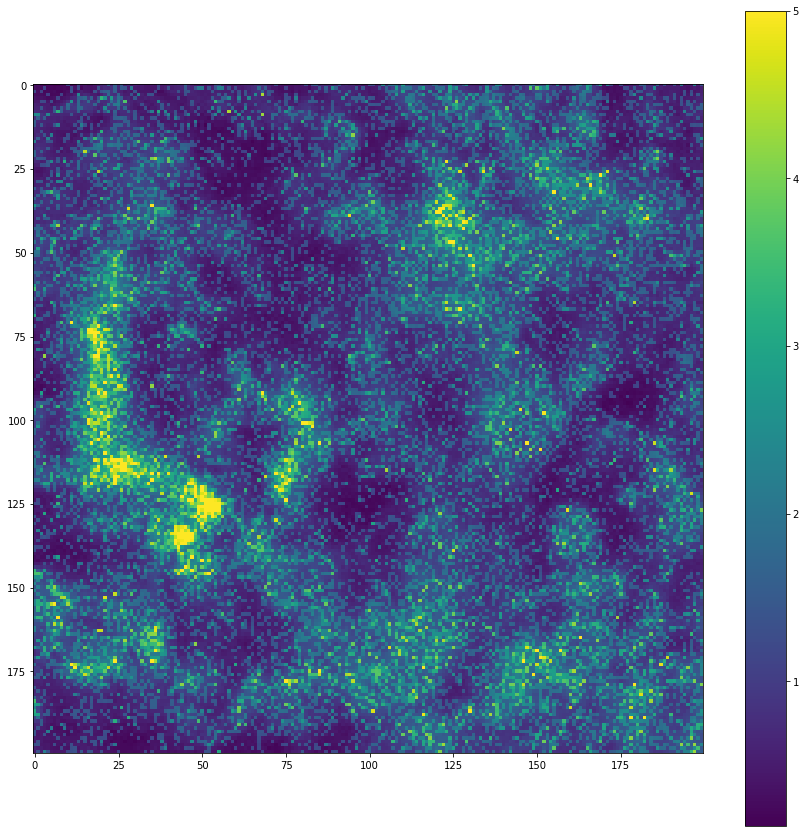

In [190]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

wiener: below gamma is 10

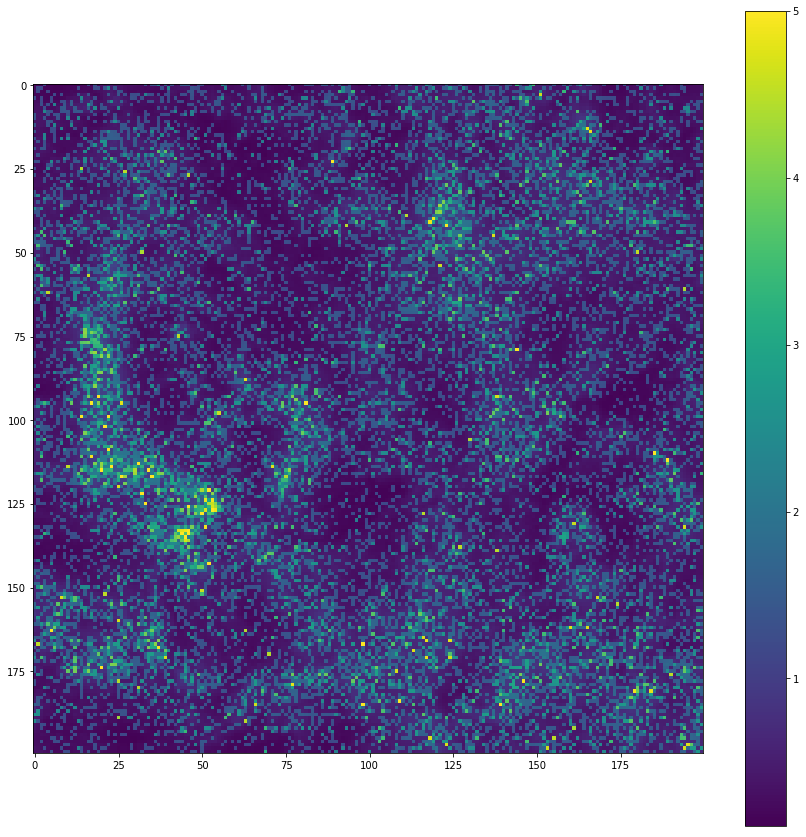

In [235]:
plt.figure(figsize=(15,15))
plt.imshow(data[600:800,600:800,12], vmax=5)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

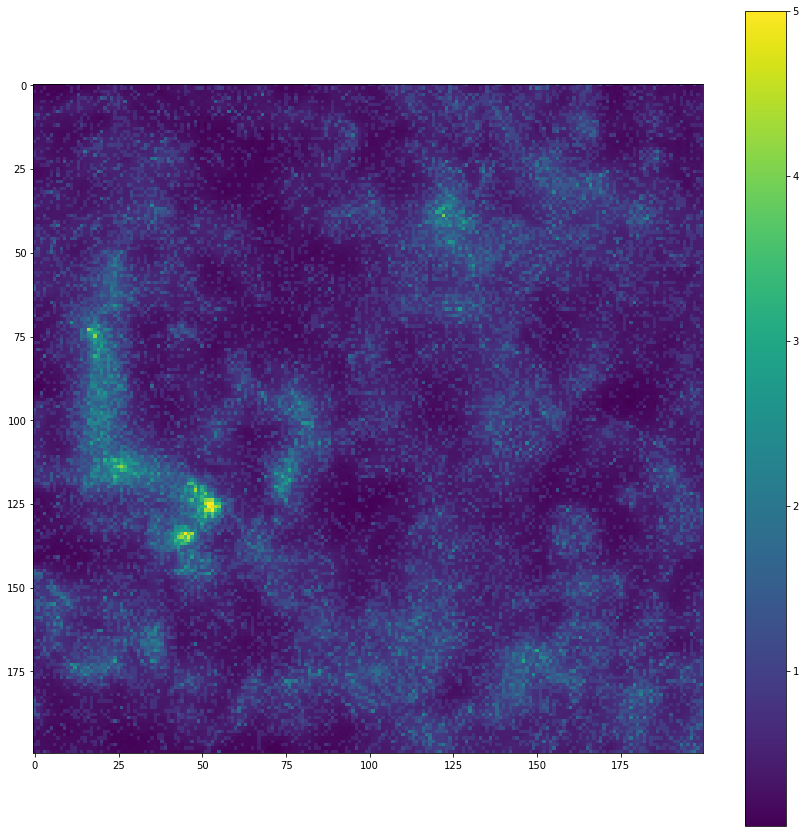

In [195]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,12], vmax=5)
plt.colorbar()
plt.show()

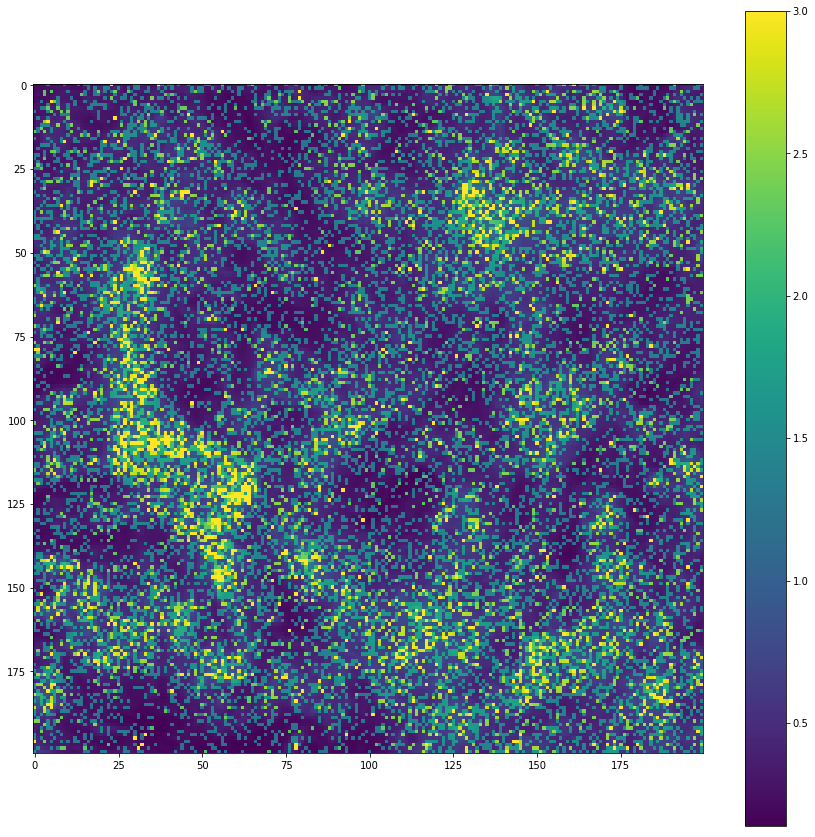

In [59]:
plt.figure(figsize=(15,15))
plt.imshow(data[600:800,600:800,50], vmax=3)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

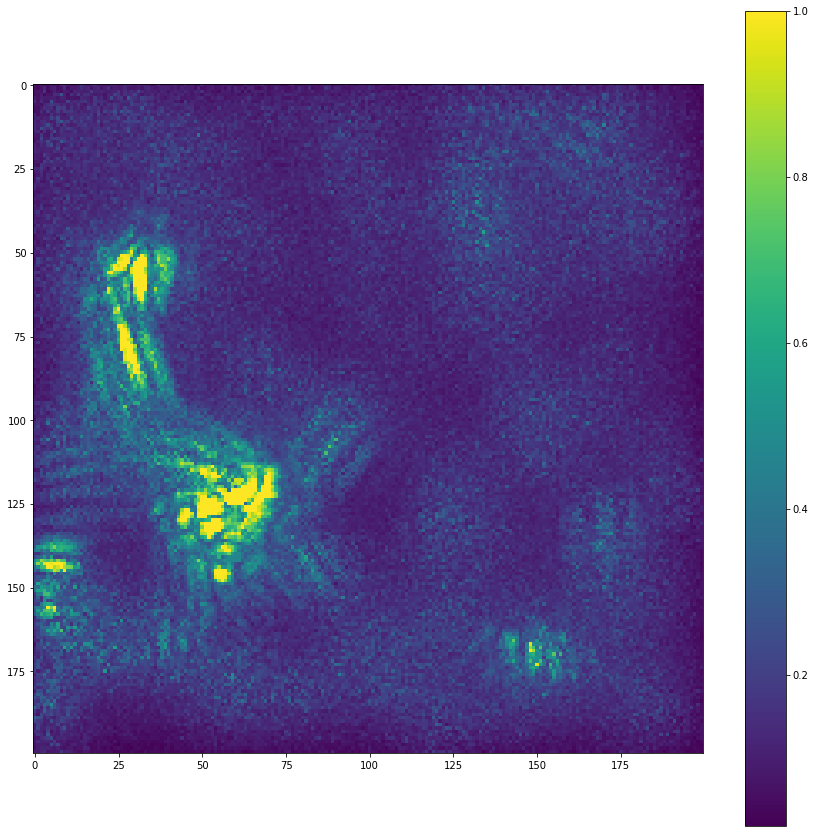

In [60]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,50], vmax=1)
plt.colorbar()
plt.show()

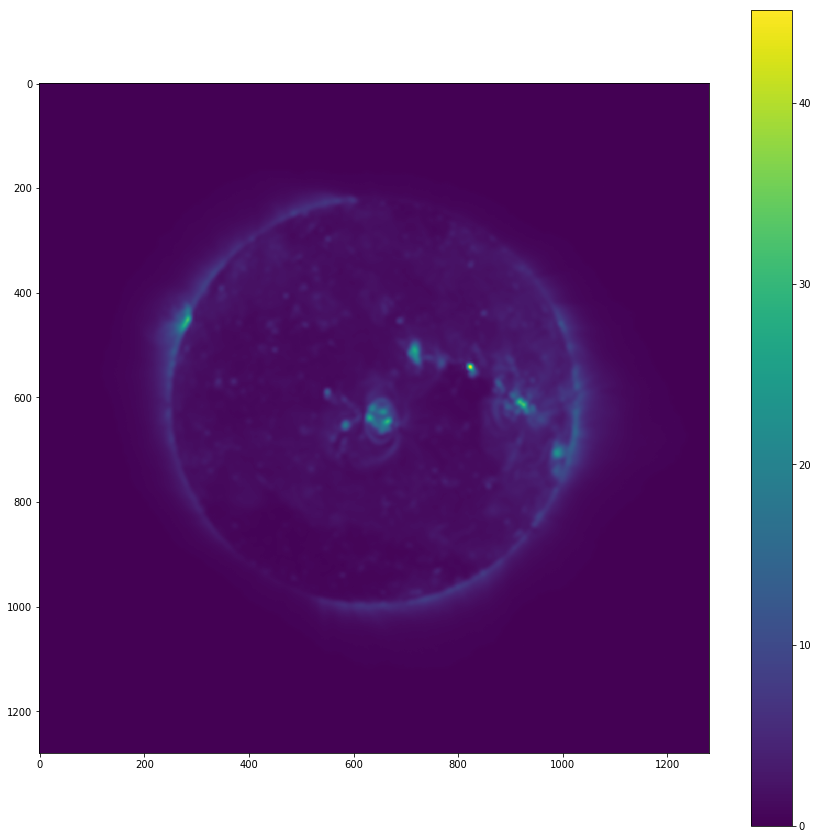

In [51]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[:,:,50])
plt.colorbar()
plt.show()

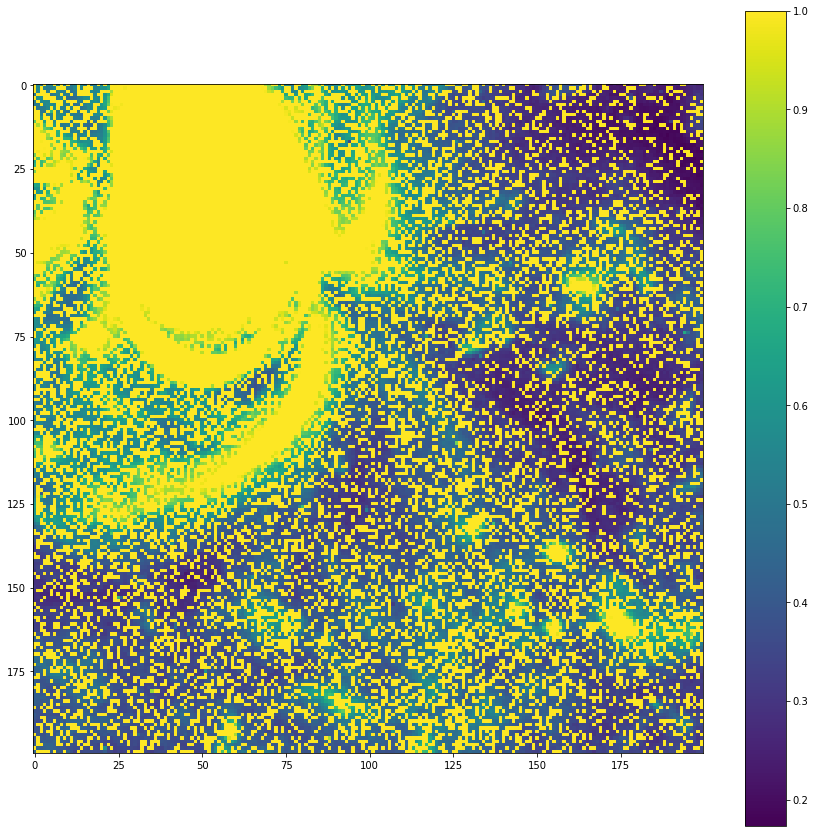

In [13]:
plt.figure(figsize=(15,15))
plt.imshow(data[600:800,600:800,50], vmax=1)
#plt.imshow(data[:,:,50])
plt.colorbar()
plt.show()

Below is with a gate filter

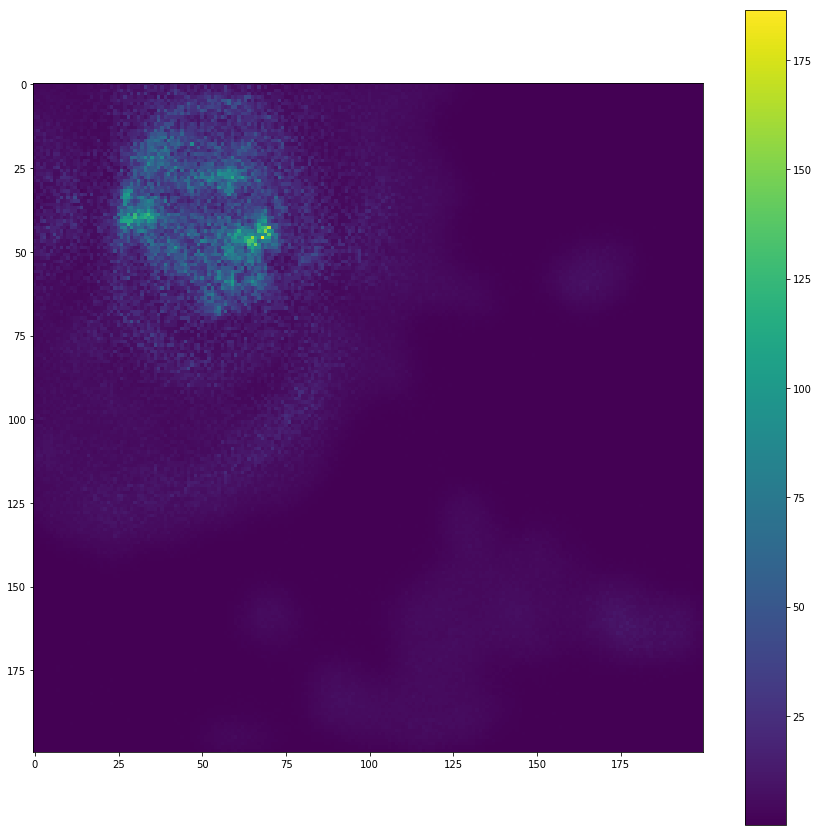

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,50])
plt.colorbar()
plt.show()

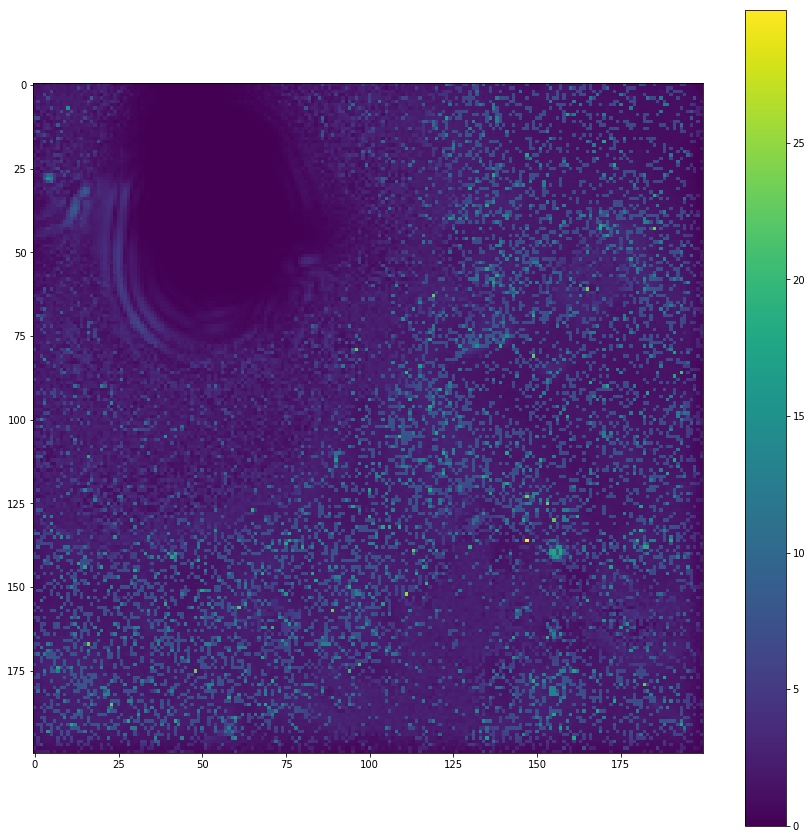

In [19]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,50])
plt.colorbar()
plt.show()

Below is with a wiener filter

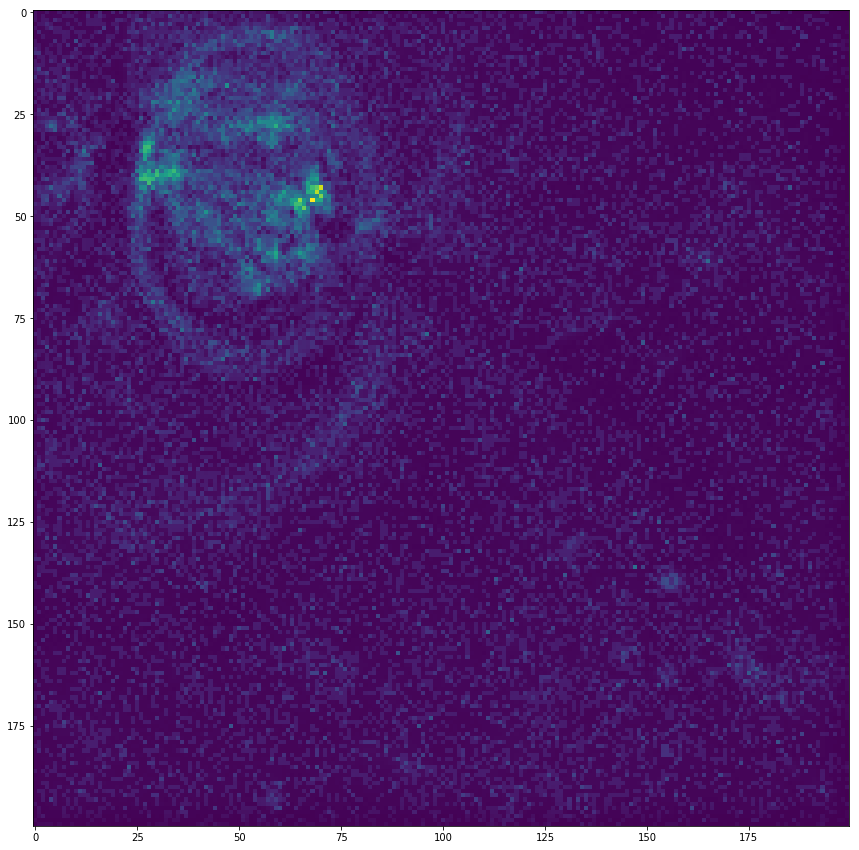

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(gated_image[600:800,600:800,50])
plt.show()